# Introducing: HistFrames
HistFrames are similar to data frames, but each row corresponds to a bin, like in a histogram. They do not aim to be fully featured histogram objects like you might find in other libraries, however. Jack of all trades; master of... also all trades.

`HistFrame`s take a Binning object and an optional column name for the first column.

In [1]:
import pyNUISANCE as pn
hf = pn.HistFrame(pn.Binning.lin_space(0,10,50), "MCPrediction")
print(hf) #the printer only prints the first 20 rows by default

 ----------------------------
 | bin | MCPrediction | err |
 ----------------------------
 |   0 |            0 |   0 |
 |   1 |            0 |   0 |
 |   2 |            0 |   0 |
 |   3 |            0 |   0 |
 |   4 |            0 |   0 |
 |   5 |            0 |   0 |
 |   6 |            0 |   0 |
 |   7 |            0 |   0 |
 |   8 |            0 |   0 |
 |   9 |            0 |   0 |
 |  10 |            0 |   0 |
 |  11 |            0 |   0 |
 |  12 |            0 |   0 |
 |  13 |            0 |   0 |
 |  14 |            0 |   0 |
 |  15 |            0 |   0 |
 |  16 |            0 |   0 |
 |  17 |            0 |   0 |
 |  18 |            0 |   0 |
 |  19 |            0 |   0 |
 |  20 |            0 |   0 |
 |          ... | ... |
 ----------------------------


We can then add an entry to a bin

In [2]:
import pyProSelecta as pps

evs = pn.EventSource("dune_argon_sf_10mega.nuwro.pb.gz")
if not evs:
    print("Error: failed to open input file")

def enu_GeV(ev):
    bpart = pps.sel.Beam(ev,14)
    if not bpart:
        return pn.HistFrame.missing_datum
    return bpart.momentum().e() * 1E-3
    
hf.reset() # reset it so that repeated running of this cell doesn't keep filling the histo
ev, cvw = evs.first()
enu = enu_GeV(ev)
hf.fill(enu, cvw) # for correctly normalizable distributions that work for different generators 
                  # we *always* need to keep track of the weights, even if they're all '1' for 
                  # our testing generator
print(hf)

 ----------------------------
 | bin | MCPrediction | err |
 ----------------------------
 |   0 |            0 |   0 |
 |   1 |            0 |   0 |
 |   2 |            0 |   0 |
 |   3 |            0 |   0 |
 |   4 |            0 |   0 |
 |   5 |            0 |   0 |
 |   6 |            0 |   0 |
 |   7 |            0 |   0 |
 |   8 |            0 |   0 |
 |   9 |            0 |   0 |
 |  10 |            0 |   0 |
 |  11 |            1 |   1 |
 |  12 |            0 |   0 |
 |  13 |            0 |   0 |
 |  14 |            0 |   0 |
 |  15 |            0 |   0 |
 |  16 |            0 |   0 |
 |  17 |            0 |   0 |
 |  18 |            0 |   0 |
 |  19 |            0 |   0 |
 |  20 |            0 |   0 |
 |          ... | ... |
 ----------------------------


Lets make a more sensibly binned histogram and fill it with a few events

### Filling in a loop

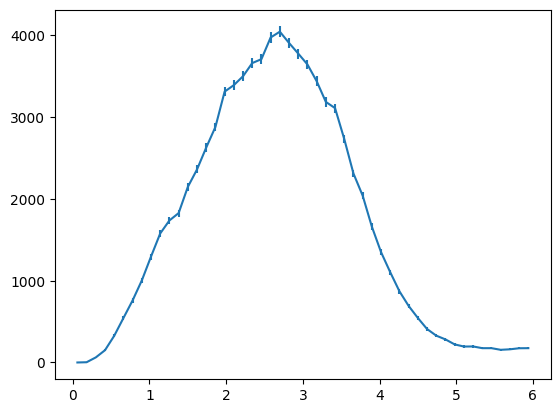

In [3]:
import matplotlib.pyplot as plt
import numpy as np

hf = pn.HistFrame(pn.Binning.lin_space(0,6,50, "E_{nu} [GeV]"), "mc")
for i, (ev, cvw) in enumerate(evs):
    hf.fill(enu_GeV(ev),cvw)
    if i >= 1E5:
        break

plt.errorbar(pn.Binning.get_bin_centers1D(hf.binning.bins),
             hf.sumweights[:,0],yerr=np.sqrt(hf.variances[:,0]))
plt.show()

### Filling directly from an EventFrame

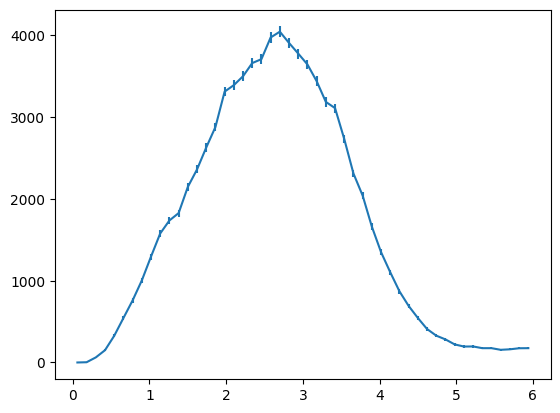

In [4]:
hf = pn.HistFrame(pn.Binning.lin_space(0,6,50, "E_{nu} [GeV]"), "mc")
fg = pn.EventFrameGen(evs,int(1E4)).limit(1E5).add_column("enu_GeV",enu_GeV)
batch = fg.first()

while batch.rows():
    hf.fill_from_EventFrame(batch,["enu_GeV"])
    batch = fg.next()

plt.errorbar(pn.Binning.get_bin_centers1D(hf.binning.bins),
             hf.sumweights[:,0],yerr=np.sqrt(hf.variances[:,0]))
plt.show()

### Filling directly from an EventFrameGen

This is inefficient except for filling a single histogram

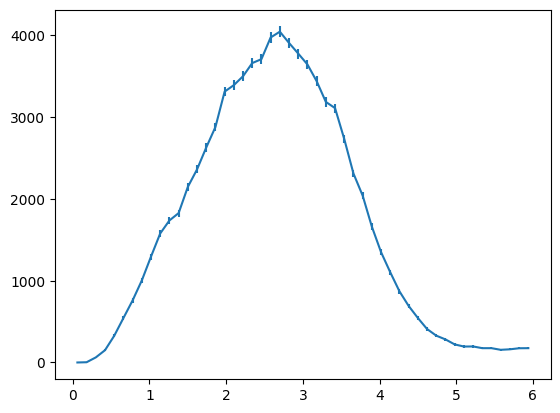

In [5]:
hf = pn.HistFrame(pn.Binning.lin_space(0,6,50, "E_{nu} [GeV]"), "mc")

fg = pn.EventFrameGen(evs,int(1E4)).limit(1E5).add_column("enu_GeV",enu_GeV)

hf.fill_from_EventFrameGen(fg,["enu_GeV"])

plt.errorbar(pn.Binning.get_bin_centers1D(hf.binning.bins),
             hf.sumweights[:,0],yerr=np.sqrt(hf.variances[:,0]))
plt.show()

### More Advanced Still

In [6]:
pps.load_text("""
double IsCCQE(HepMC3::GenEvent const &ev){
  return (ev.attribute<HepMC3::IntAttribute>("signal_process_id")->value()==200);
}
double chan_subsample(HepMC3::GenEvent const &ev){
  int proc_id = ev.attribute<HepMC3::IntAttribute>("signal_process_id")->value();

  if((200 <= proc_id) && (proc_id < 300)){
      return 1;
  } else if((300 <= proc_id) && (proc_id < 400)){
      return 2;
  } else if((400 <= proc_id) && (proc_id < 500)){
      return 3;
  }
  return 0;
}
""")

True

In [7]:
fg = pn.EventFrameGen(evs,int(1E4)).limit(1E5)\
    .add_column("enu_GeV",enu_GeV)\
    .add_column("IsCCQE",pps.project.IsCCQE)\
    .add_column("chan_subsample",pps.project.chan_subsample)
print(fg.first())

 ---------------------------------------------------------------------------
 | event.number | weight.cv | process.id | enu_GeV | IsCCQE | chan_subsam$ |
 ---------------------------------------------------------------------------
 |            0 |         1 |        500 |   2.275 |      0 |            0 |
 |            1 |         1 |        600 |    14.3 |      0 |            0 |
 |            2 |         1 |        600 |    2.86 |      0 |            0 |
 |            3 |         1 |        600 |   3.728 |      0 |            0 |
 |            4 |         1 |        600 |    9.08 |      0 |            0 |
 |            5 |         1 |        600 |   3.237 |      0 |            0 |
 |            6 |         1 |        400 |   2.473 |      0 |            3 |
 |            7 |         1 |        200 |   1.916 |      1 |            1 |
 |            8 |         1 |        600 |   1.988 |      0 |            0 |
 |            9 |         1 |        650 |   3.671 |      0 |            0 |

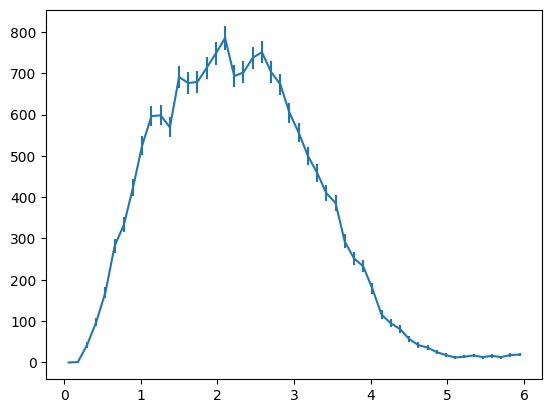

In [8]:
hf_CCQE = pn.HistFrame(pn.Binning.lin_space(0,6,50, "E_{nu} [GeV]"), "mc")

batch = fg.first()
while batch.rows():
    hf_CCQE.fill_from_EventFrame_if(batch, "IsCCQE", ["enu_GeV"])
    batch = fg.next()

plt.errorbar(pn.Binning.get_bin_centers1D(hf_CCQE.binning.bins),
             hf_CCQE.sumweights[:,0],yerr=np.sqrt(hf_CCQE.variances[:,0]))
plt.show()

In [19]:
hf_multimode = pn.HistFrame(pn.Binning.lin_space(0,6,50, "E_{nu} [GeV]"), "mc")
kccqe = hf_multimode.add_column("CCQE")
k2p2h = hf_multimode.add_column("2p2h")
hf_multimode.add_column("1pi")

def sample(ev):
    ifev == isccqe:
      return kccqe

batch = fg.first()
while batch.rows():
    hf_multimode.fill_columns_from_EventFrame(batch, project_columns=["enu_GeV"], sample_column="chan_subsample")
    batch = fg.next()

for i,ci in enumerate(hf_multimode.column_info):
    plt.errorbar(pn.Binning.get_bin_centers1D(hf_multimode.binning.bins),
             hf_multimode.sumweights[:,i],yerr=np.sqrt(hf_multimode.variances[:,i]), label=ci.name)
    
plt.legend()
plt.show()

IndentationError: expected an indented block (1133834831.py, line 8)

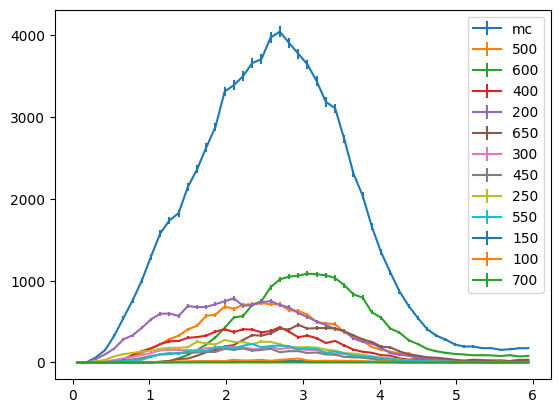

In [10]:
hf_auto_multimode = pn.HistFrame(pn.Binning.lin_space(0,6,50, "E_{nu} [GeV]"), "mc")

batch = fg.first()
while batch.rows():
    hf_auto_multimode.fill_procid_columns_from_EventFrame(batch, ["enu_GeV"])
    batch = fg.next()

for i,ci in enumerate(hf_auto_multimode.column_info):
    plt.errorbar(pn.Binning.get_bin_centers1D(hf_auto_multimode.binning.bins),
             hf_auto_multimode.sumweights[:,i],yerr=np.sqrt(hf_auto_multimode.variances[:,i]), label=ci.name)

plt.legend()
plt.show()

## 2D Histograms

As we saw in the [binning notebook](https://github.com/NUISANCEMC/eventinput/blob/main/notebooks/binning.ipynb), we can make multi-dimensional binnings. These can be used to instantiate `HistFrame`s.

In [11]:
def ptpz(ev):
    bpart = pps.sel.Beam(ev,14)
    if not bpart:
        return [pn.EventFrame.missing_datum, pn.EventFrame.missing_datum]
    beam_pid = bpart.pid()
    cc_lep_pid = (beam_pid - 1) if (beam_pid > 0) else (beam_pid + 1);
    lep = pps.sel.OutPartHM(ev, int(cc_lep_pid))
    if not lep:
        return [pn.EventFrame.missing_datum, pn.EventFrame.missing_datum]
    
    return [lep.momentum().pz() * 1E-3, lep.momentum().pt() * 1E-3]

In [12]:
hf_ptpz = pn.HistFrame(pn.Binning.lin_spaceND([[0,3,75],[0,1,25]], ["pz","pt"]))

fg = pn.EventFrameGen(evs).limit(1E6)\
    .add_columns(["pz","pt"],ptpz)

batch = fg.first()
while batch.rows():
    hf_ptpz.fill_procid_columns_from_EventFrame(batch, ["pz","pt"])
    batch = fg.next()

Drawing a 2D histogram is a little more fiddly in matplotlib (or plotly for that matter)

From [numpy.histogram2d](https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html) and [matplotlib.pyplot.pcolormesh](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.pcolormesh.html):

```
(X[i+1, j], Y[i+1, j])       (X[i+1, j+1], Y[i+1, j+1])
                      ●╶───╴●
                      │     │
                      ●╶───╴●
    (X[i, j], Y[i, j])       (X[i, j+1], Y[i, j+1])
```

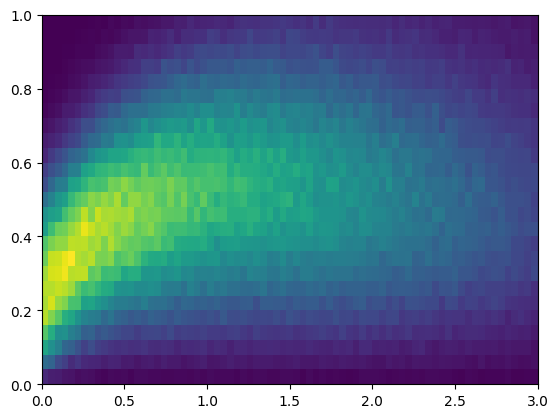

In [13]:
nbins = len(hf_ptpz.binning.bins)
X = np.zeros((2*nbins,2))
Y = np.zeros((2*nbins,2))
C = np.zeros(((2*nbins)-1,1))
for i,bin in enumerate(hf_ptpz.binning.bins):
    X[2*i,0] = bin[0].low
    Y[2*i,0] = bin[1].low
    
    X[2*i + 1,0] = bin[0].low
    Y[2*i + 1,0] = bin[1].high
    
    X[2*i, 1] = bin[0].high
    Y[2*i, 1] = bin[1].low

    X[2*i + 1, 1] = bin[0].high
    Y[2*i + 1, 1] = bin[1].high

    C[2*i,0] = hf_ptpz.sumweights[i,0]
    if (2*i + 2) != (2*nbins):
        C[2*i + 1,0] = hf_ptpz.sumweights[i,0]
        
plt.pcolormesh(X, Y, C)
plt.show()

we provide a helper function for building the pcolormesh data structures following the above logic

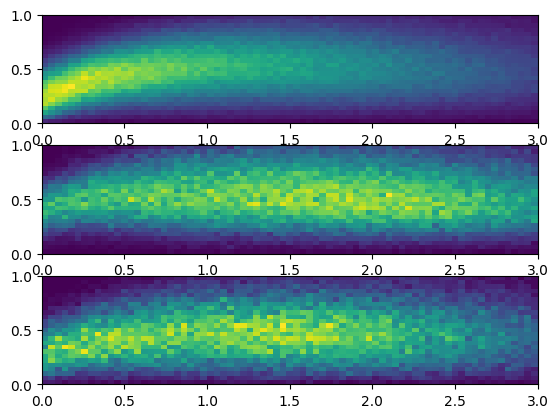

In [14]:
fig, (ax_all,ax_qe,ax_1pi) = plt.subplots(3,1)

pcmdata = pn.convert.HistFrame.to_mpl_pcolormesh(hf_ptpz)
ax_all.pcolormesh(pcmdata["X"], pcmdata["Y"], pcmdata["C"])

pcmdata = pn.convert.HistFrame.to_mpl_pcolormesh(hf_ptpz,hf_ptpz.find_column_index("200"))
ax_qe.pcolormesh(pcmdata["X"], pcmdata["Y"], pcmdata["C"])

pcmdata = pn.convert.HistFrame.to_mpl_pcolormesh(hf_ptpz,hf_ptpz.find_column_index("400"))
ax_1pi.pcolormesh(pcmdata["X"], pcmdata["Y"], pcmdata["C"])

fig.show()

## Projections
For rectangular binnings where projections onto lower dimensions are well defined, we can make histogram projections

In [15]:
hf_pt = pn.HistFrame.project(hf_ptpz,1)
print(hf_pt.binning)
print(hf_pt)
print("nfills: %s" % hf_pt.nfills)

Axis lables: ["pt"]
Bins: [
  0: [(0.00 - 0.04)]
  1: [(0.04 - 0.08)]
  2: [(0.08 - 0.12)]
  3: [(0.12 - 0.16)]
  4: [(0.16 - 0.20)]
  5: [(0.20 - 0.24)]
  6: [(0.24 - 0.28)]
  7: [(0.28 - 0.32)]
  8: [(0.32 - 0.36)]
  9: [(0.36 - 0.40)]
  10: [(0.40 - 0.44)]
  11: [(0.44 - 0.48)]
  12: [(0.48 - 0.52)]
  13: [(0.52 - 0.56)]
  14: [(0.56 - 0.60)]
  15: [(0.60 - 0.64)]
  16: [(0.64 - 0.68)]
  17: [(0.68 - 0.72)]
  18: [(0.72 - 0.76)]
  19: [(0.76 - 0.80)]
  20: [(0.80 - 0.84)]
  21: [(0.84 - 0.88)]
  22: [(0.88 - 0.92)]
  23: [(0.92 - 0.96)]
  24: [(0.96 - 1.00)]
]

 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 | bin |        mc |   err |  500 |   err |       600 |   err |  400 |   err |  200 |   err | 650 | err |  300 |   err | 450 | err | 250 | err | 550 | err | 150 | err | 100 |   err | 700 | err |
 --------------------------------------

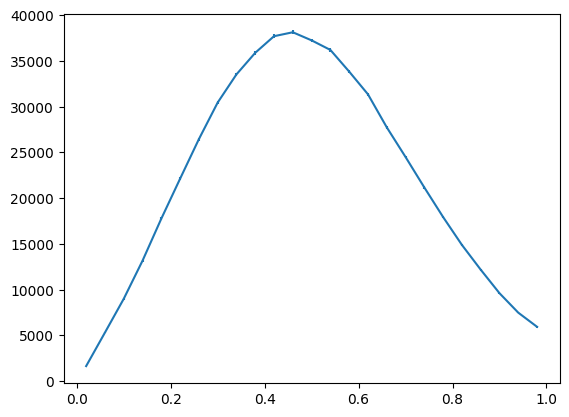

In [16]:
plt.errorbar(pn.Binning.get_bin_centers1D(hf_pt.binning.bins),
             hf_pt.sumweights[:,0],yerr=np.sqrt(hf_pt.variances[:,0]))
plt.show()

While it is unlikely that we would want to continue calling fill on a projection histogram, it is supported.

In [17]:
hf_pt.fill(0.5,10000)
print(hf_pt)
print("nfills: %s" % hf_pt.nfills)

 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 | bin |        mc |   err |  500 |   err |       600 |   err |  400 |   err |  200 |   err | 650 | err |  300 |   err | 450 | err | 250 | err | 550 | err | 150 | err | 100 |   err | 700 | err |
 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 |   0 |      1646 | 40.57 |  210 | 14.49 |       660 | 25.69 |  292 | 17.09 |  163 | 12.77 |   0 |   0 |  149 | 12.21 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 | 172 | 13.11 |   0 |   0 |
 |   1 |      5307 | 72.85 |  788 | 28.07 |      2127 | 46.12 |  900 |    30 |  552 | 23.49 |   0 |   0 |  421 | 20.52 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 | 519 | 22.78 |   0 |   0 |
 |   2 |      8993 | 94.8

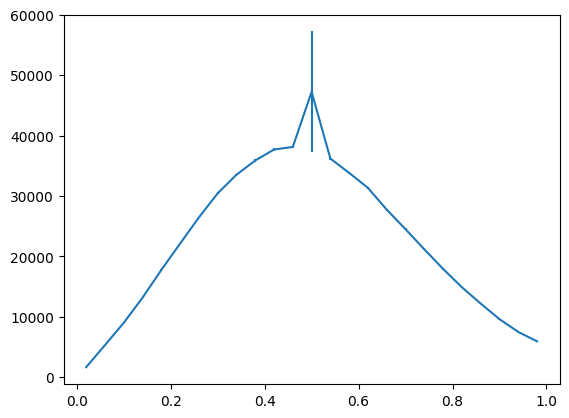

In [18]:
plt.errorbar(pn.Binning.get_bin_centers1D(hf_pt.binning.bins),
             hf_pt.sumweights[:,0],yerr=np.sqrt(hf_pt.variances[:,0]))
plt.show()